## Identifying seasonal patterns in a time series

When plotting isn't enough, time series decomposition is useful. Decomposition splits the time series into a trend, seasonal, and residual component.

In [78]:
import pandas as pd

df = pd.read_csv('data/air-passengers.csv')

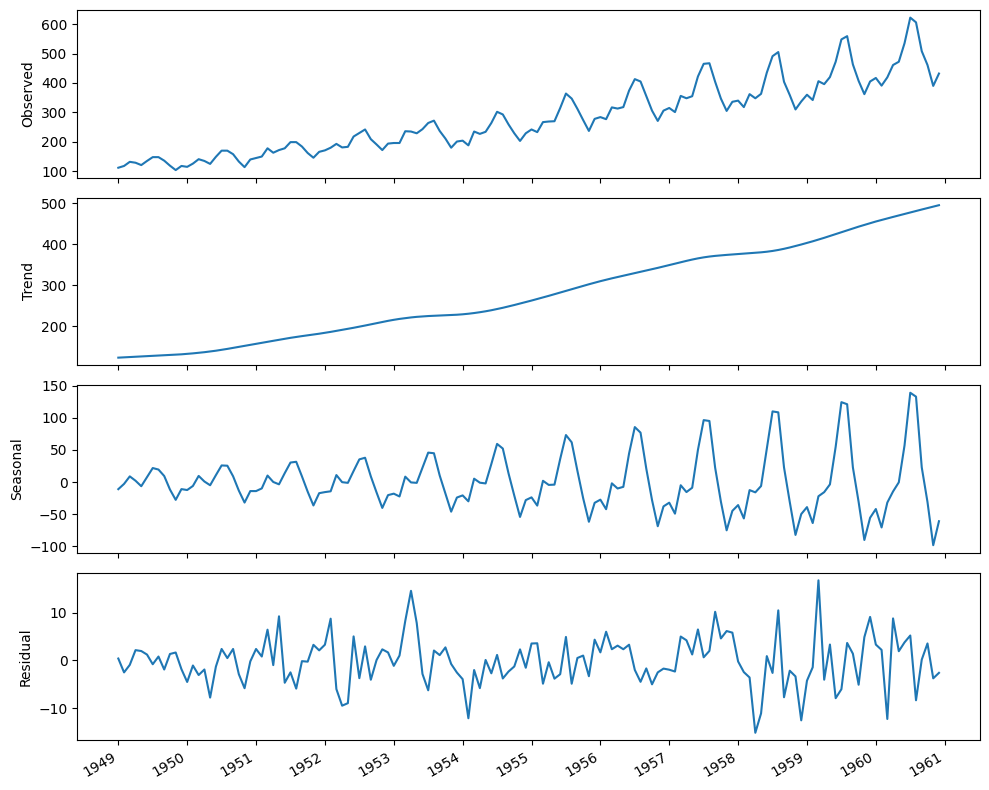

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from statsmodels.tsa.seasonal import STL

decomposition = STL(df['Passengers'], period=12).fit()

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,8))
axs: list[Axes]

axs[0].plot(decomposition.observed)
axs[0].set_ylabel('Observed')

axs[1].plot(decomposition.trend)
axs[1].set_ylabel('Trend')

axs[2].plot(decomposition.seasonal)
axs[2].set_ylabel('Seasonal')

axs[3].plot(decomposition.resid)
axs[3].set_ylabel('Residual')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
fig.tight_layout()

## Forecasting with $\text{ARIMA}(p,d,q)$ model.

We'll use $\text{ARIMA}(p,d,q)$ as a benchmark to compare with our $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model later on.

In [80]:
from typing import Union
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: Union[pd.Series, np.ndarray]):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    
test_stationarity(df['Passengers'])

ADF Statistic: 0.815
p-value: 0.992


With a ADF statistic that is not a large negative number, and a p-value that is greater than 0.05, we cannot reject the null hypothesis that the time series is non-stationary i.e. it is non-stationary. So let's difference it and test for stationarity again.

In [81]:
diff = np.diff(df['Passengers'], n=1)
test_stationarity(diff)

ADF Statistic: -2.829
p-value: 0.054


In [82]:
diff2 = np.diff(df['Passengers'], n=2)
test_stationarity(diff2)

ADF Statistic: -16.384
p-value: 0.000


In [83]:
from itertools import product

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0

s = 12

# generate all possible combinations of (p,d,q)(P,D,Q)
ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [84]:
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)

pqPQ = tuple[int, int, int, int]

def optimize_SARIMA(
    endog: Union[pd.Series, list], 
    order_list: list[pqPQ],
    d: int,
    D: int,
    s: int,
) -> pd.DataFrame:
    results: list[tuple(pqPQ, np.float64)] = []
    for order in tqdm(order_list):
        p, q, P, Q = order
        try:
            model = SARIMAX(
                endog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append((order, aic))
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    result_df = (result_df
                 .sort_values(by='AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

In [85]:
train = df['Passengers'][:-12]
test = df['Passengers'][-12:]

In [86]:
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p, q, P, Q)",AIC
0,"(11, 3, 0, 0)",1016.840452
1,"(11, 4, 0, 0)",1019.035080
2,"(11, 5, 0, 0)",1020.378370
3,"(12, 0, 0, 0)",1020.933352
4,"(11, 1, 0, 0)",1021.022541
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


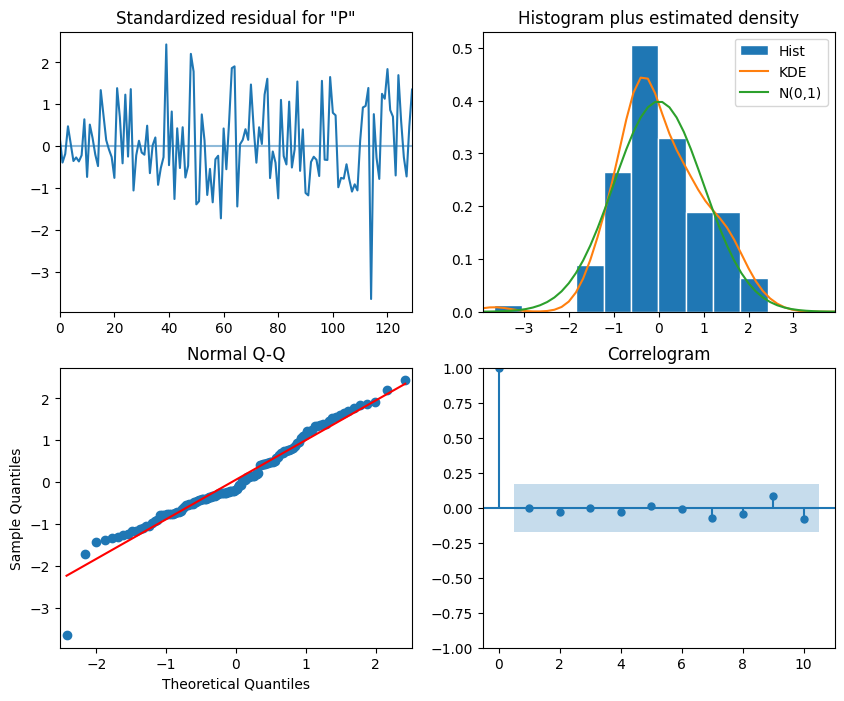

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

ARIMA_model = SARIMAX(train, order=(11,d,3), simple_differencing=False)
ARIMA_model_fit: SARIMAXResults = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [96]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def get_sarimax_resid_pvalues(model_results: SARIMAXResults):
    residuals = model_results.resid
    lb_df = acorr_ljungbox(residuals, np.arange(1, 11))
    lb_df = lb_df.sort_values(by='lb_pvalue', ascending=True)
    return lb_df

get_sarimax_resid_pvalues(ARIMA_model_fit)

,lb_stat,lb_pvalue
1,6.554295,0.010463
2,6.681091,0.035418
3,6.960210,0.073177
4,7.752339,0.101083
5,8.395802,0.135729
6,8.680435,0.192364
7,9.492668,0.219192
8,9.731069,0.284411
10,11.535590,0.317339
9,9.741498,0.371815


All the returned p-values are >0.05 except the 1st two i.e. we reject the null hypothesis with a 5% chance of being wrong. However, the 3rd value and onward are all >0.05, so we reject the null hypothesis that residuals are correlated starting at lag 3. 

This appears to conflict with our graphical analysis which shows that the residuals resemble white noise at lags 1 and 2 as well. Therefore, the ARIMA model is not capturing all the information from the data.

In [89]:
train = df['Passengers'][:-12]
test = df['Passengers'][-12:]

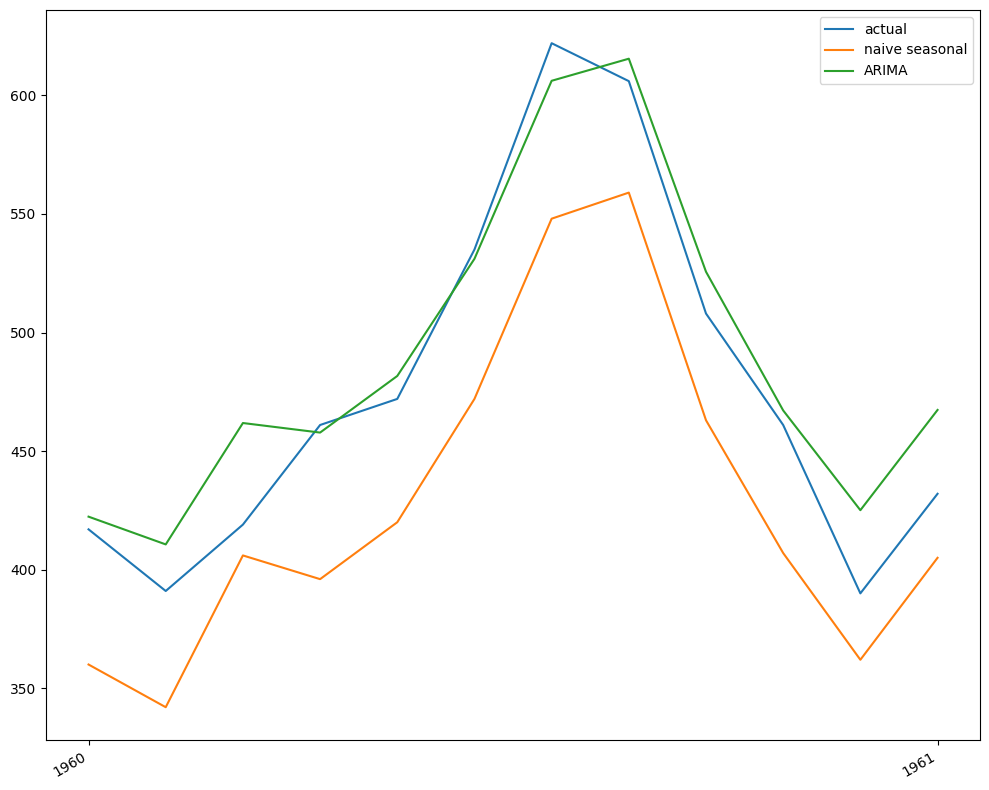

In [98]:
from statsmodels.tsa.statespace.mlemodel import PredictionResults

end = 145
ARIMA_pred_results: PredictionResults = ARIMA_model_fit.get_prediction(end-13, end-1)
ARIMA_pred: np.ndarray = ARIMA_pred_results.predicted_mean

test = df.iloc[-12:]

test = test.assign(
    naive_seasonal=df['Passengers'].iloc[-24:-12].values,
    ARIMA_pred=ARIMA_pred
)

fig, ax = plt.subplots(figsize=(10,8))
ax: Axes

ax.plot(test['Passengers'], label='actual')
ax.plot(test['naive_seasonal'], label='naive seasonal')
ax.plot(test['ARIMA_pred'], label='ARIMA')

ax.set_xticks(np.arange(end-1-12, end, 11), np.arange(1960, 1962, 1))
ax.legend()

fig.autofmt_xdate()
fig.tight_layout()

In [93]:
diff = np.diff(df['Passengers'], n=1)
test_stationarity(diff) # non-stationary

seasonal_diff = np.diff(diff, n=12)
test_stationarity(seasonal_diff)

# d = 1, D = 1

ADF Statistic: -2.829
p-value: 0.054
ADF Statistic: -17.625
p-value: 0.000


In [94]:
ps = range(1, 3)
qs = range(1, 3)
Ps = range(1, 3)
Qs = range(1, 3)

SARIMA_order_list: list[pqPQ] = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p, q, P, Q)",AIC
0,"(2, 1, 1, 2)",892.236616
1,"(2, 1, 2, 1)",894.191065
2,"(2, 2, 1, 2)",895.752763
3,"(1, 1, 1, 2)",896.218892
4,"(2, 2, 2, 1)",896.804298
5,"(1, 1, 2, 1)",896.976108
6,"(1, 2, 1, 2)",898.163497
7,"(1, 2, 2, 1)",898.934598
8,"(1, 1, 2, 2)",899.911444
9,"(2, 2, 2, 2)",899.921955


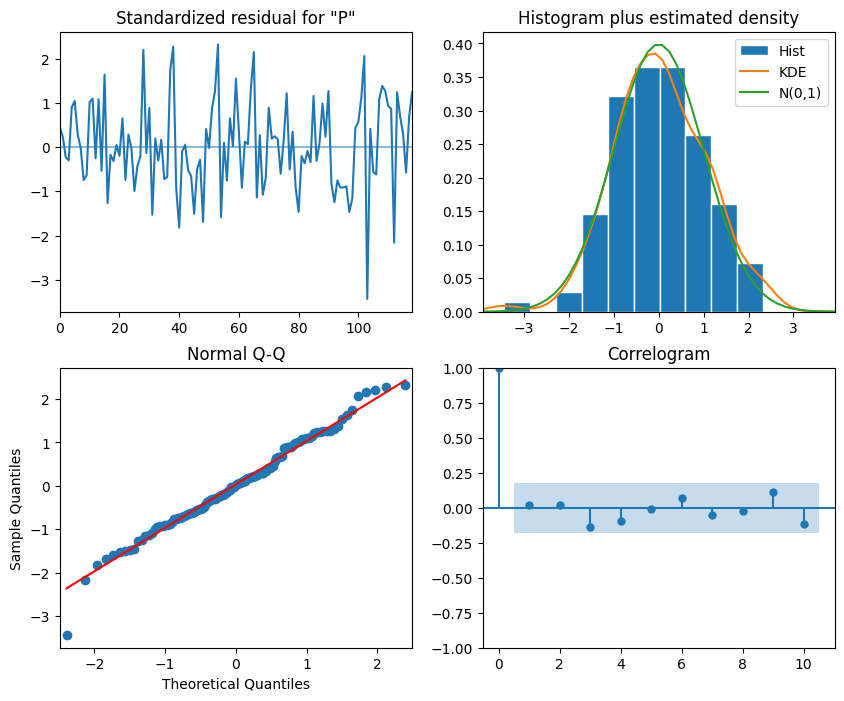

In [95]:
SARIMA_model = SARIMAX(train, order=(2, d, 1), seasonal_order=(1, D, 2, s),
                       simple_differencing=False)
SARIMA_model_fit: SARIMAXResults = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [97]:
get_sarimax_resid_pvalues(SARIMA_model_fit)

,lb_stat,lb_pvalue
2,0.748211,0.687904
3,1.023383,0.795594
4,1.228505,0.873383
10,4.980054,0.892506
5,1.439021,0.919998
7,2.309172,0.940769
6,1.714319,0.944010
8,2.722866,0.950528
1,0.003810,0.950781
9,2.739007,0.973750


All the p-values >0.05, so we do not reject the null hypothesis, and we conclude that all residuals are independent and uncorrelated, just like white noise.

In [100]:
SARIMA_pred = SARIMA_model_fit.get_prediction(end-12-1, end-1).predicted_mean
test = test.assign(SARIMA_pred=SARIMA_pred)

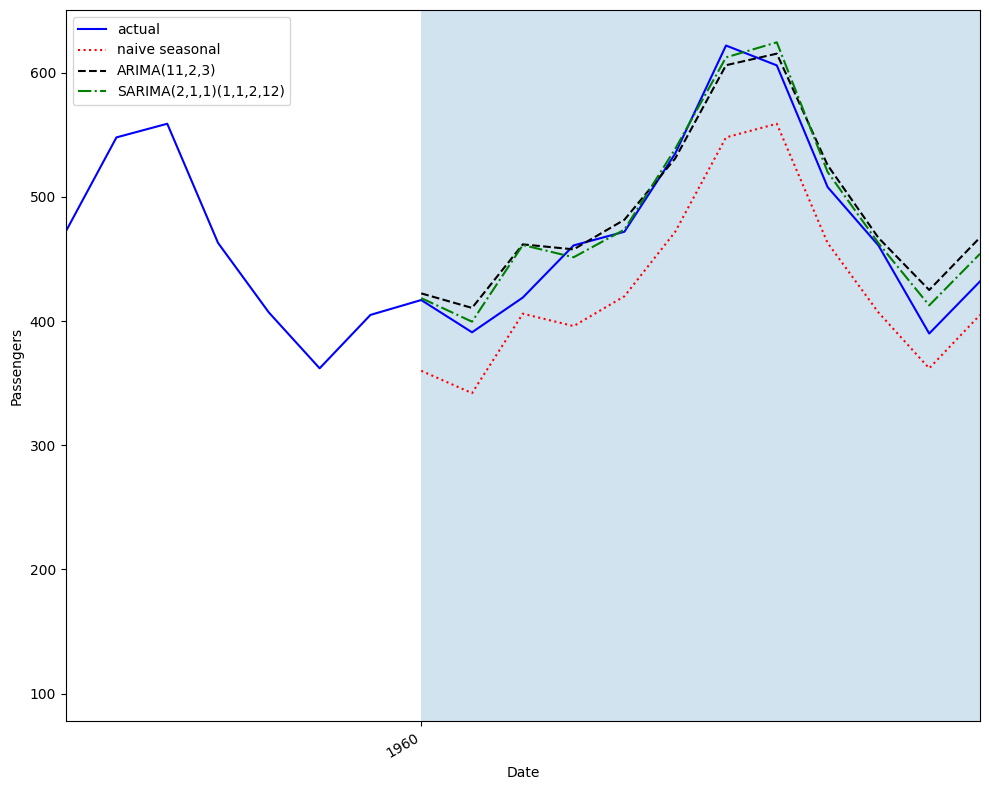

In [110]:
fig, ax = plt.subplots(figsize=(10,8))
ax: Axes

ax.plot(df['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.axvspan(end-13, end-1, alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_xticks(np.arange(0, end, 12), np.arange(1949, 1962, 1))
ax.set_xlim(end-20, end-2)
ax.legend(loc=2)

fig.autofmt_xdate()
fig.tight_layout()

In [113]:
from sklearn.metrics import mean_absolute_percentage_error

mape_naive_seasonal = mean_absolute_percentage_error(test['Passengers'], 
                                                     test['naive_seasonal'])
mape_ARIMA = mean_absolute_percentage_error(test['Passengers'],
                                            test['ARIMA_pred'])
mape_SARIMA = mean_absolute_percentage_error(test['Passengers'],
                                             test['SARIMA_pred'])

print(f'MAPE of naive seasonal: {100*mape_naive_seasonal:.2f}%')
print(f'MAPE of ARIMA: {100*mape_ARIMA:.2f}%')
print(f'MAPE of SARIMA: {100*mape_SARIMA:.2f}%')

MAPE of naive seasonal: 9.99%
MAPE of ARIMA: 3.84%
MAPE of SARIMA: 2.85%
